<a href="https://colab.research.google.com/github/ChriAsc/tweetsBERT/blob/main/BERT_tweet_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine-Tuning BERT for Text Classification

### Libraries & imports

In [ ]:
#connettere Colab a Drive per caricare un dataset
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!pip install transformers
!pip install datasets


import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
#from nltk.corpus import stopwords
import nltk
import re
from tabulate import tabulate
from tqdm import trange
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import datasets
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding, TFBertForSequenceClassification
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup, get_scheduler
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 4.9 MB/s eta 0:00:0

In [ ]:
# GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))
print(device)

Tesla T4
cuda:0


## Dataset import

In [ ]:
# Labeled dataset
dataset = load_dataset("cardiffnlp/tweet_sentiment_multilingual", "italian")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset tweet_sentiment_multilingual downloaded and prepared to /root/.cache/huggingface/datasets/cardiffnlp___tweet_sentiment_multilingual/italian/0.1.0/936afd3cde120393429606f681b3b48d526873c45114068973f71e296ce80605. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Russia-Ukraine tweets (unlabeled)

#Link drive christian
tweets_full = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Science/BERT/tweets_war.csv')
tweets_1 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Science/BERT/20221211.csv')
tweets_2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Science/BERT/20220901.csv')
tweets_3 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Science/BERT/20221010.csv')
tweets_4 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Science/BERT/20230112.csv')
tweets_5 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Science/BERT/20230120.csv')

'''
#Link drive ale
tweets_full = pd.read_csv('/content/gdrive/MyDrive/Data Science/BERT/tweets_war.csv')
tweets_1 = pd.read_csv('/content/gdrive/MyDrive/Data Science/BERT/20221211.csv')
tweets_2 = pd.read_csv('/content/gdrive/MyDrive/Data Science/BERT/20220901.csv')
tweets_3 = pd.read_csv('/content/gdrive/MyDrive/Data Science/BERT/20221010.csv')
tweets_4 = pd.read_csv('/content/gdrive/MyDrive/Data Science/BERT/20230112.csv')
tweets_5 = pd.read_csv('/content/gdrive/MyDrive/Data Science/BERT/20230120.csv')
'''


tweets_full = tweets_full.rename(columns={"content": "text"})



tweets_1 = tweets_1.loc[tweets_1["language"] == "it"]
tweets_1 = tweets_1[["text"]]
tweets_2 = tweets_2.loc[tweets_2["language"] == "it"]
tweets_2 = tweets_2[["text"]]
tweets_3 = tweets_3.loc[tweets_3["language"] == "it"]
tweets_3 = tweets_3[["text"]]
tweets_4 = tweets_4.loc[tweets_4["language"] == "it"]
tweets_4 = tweets_4[["text"]]
tweets_5 = tweets_5.loc[tweets_5["language"] == "it"]
tweets_5 = tweets_5[["text"]]

frame_unlabeled = [tweets_full,tweets_1,tweets_2,tweets_3,tweets_4,tweets_5]
unlabeled_df = pd.concat(frame_unlabeled)
unlabeled_df = unlabeled_df.reset_index(drop=True)
# unlabeled_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Data Science/BERT/full_tweets_war.csv', index=False,encoding='utf-8')

## Preprocessing data

In [ ]:
# extraction of different datasets
df_test = pd.DataFrame(dataset['test'] )
df_test = df_test.dropna()
df_train = pd.DataFrame(dataset['train'] )
df_train = df_train.dropna()
df_val = pd.DataFrame(dataset['validation'])
df_val = df_val.dropna()

# unique df
frame = [df_train,df_test,df_val]
df = pd.concat(frame)
df = df.reset_index(drop=True)  # necessary in order to split

df.tail()

,text,label
3028,L'Unione europea e il Governo Monti insieme ne...,1
3029,@user grazie troppo gentile :-),2
3030,@user anche io Uno di quei personaggi inutili ...,0
3031,Per SWG il movimento di Beppe #Grillo è il ter...,1
3032,@user mora tutta la vita,2


In [ ]:
#count elements for each labels
Counter(df.label)

Counter({0: 1011, 1: 1011, 2: 1011})

In [ ]:
## Shuffle Data
def shuffle(df, n=3, axis=0):     
    df = df.copy()
    random_states = [2,42,4]
    for i in range(n):
        df = df.sample(frac=1,random_state=random_states[i]) # dataframe shuffling
    return df

new_df = shuffle(df)
new_df = new_df.reset_index(drop=True)
new_df

,text,label
0,Tra la #Guzzanti e #Grillo c'è solo una differ...,1
1,Dopo i ministri del governo #Monti che illustr...,0
2,"Oh, ecco, ora sto più tranquillo: pare che Mar...",0
3,@user mi debbo complimentare con il Governo Mo...,2
4,Governo Monti crolla sulle liberalizzazioni. T...,0
...,...,...
3028,Casini a destra e sinistra: non fate i furbi e...,1
3029,Tutti gli stranieri sono orgogliosi della loro...,0
3030,#Esteri #News #news Nepal: si organizzano i so...,1
3031,Ora fate fallire il governo #monti e poi chiam...,0


## Removing Stopwords

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('italian')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub("user"," ",text)

    text = re.sub("http"," ",text)
    text = re.sub("https"," ",text)

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = ',@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# remove stopwords if needed (both labeled and unlabeled)
new_df['text'] = new_df['text'].apply(lambda x: clean_text(x))
df_test["text"] = df_test["text"].apply(lambda x: clean_text(x))
unlabeled_df['text'] = unlabeled_df['text'].apply(lambda x: clean_text(x))
new_df

,text,label
0,guzzanti grillo solo differenza medium interne...,1
1,dopo ministri governo monti illustrano manovra...,0
2,oh ecco ora pi tranquillo pare marystar gelmin...,0
3,debbo complimentare governo monti trasparenza ...,2
4,governo monti crolla liberalizzazioni taxisti ...,0
...,...,...
3028,casini destra sinistra fate furbi pavidi verso...,1
3029,stranieri orgogliosi patriatranne italiani sch...,0
3030,esteri news news nepal organizzano soccorsi in...,1
3031,ora fate fallire governo monti poi chiamateci ...,0


## Train Validation Test Split

In [ ]:
index_tr = int(len(new_df)*0.90)
index_ts = int(len(new_df)*0.95)

train_df = new_df.loc[:index_tr,:]
val_df = new_df.loc[index_tr:index_ts,:]
test_df = new_df.loc[index_ts:,:]

print('train lenght:',len(train_df))
print(train_df.groupby(['label'])['text'].count())

print('validation lenght:',len(val_df))
print(val_df.groupby(['label'])['text'].count())

print('test lenght:',len(test_df))
print(test_df.groupby(['label'])['text'].count())

train lenght: 2730
label
0    911
1    912
2    907
Name: text, dtype: int64
validation lenght: 153
label
0    53
1    42
2    58
Name: text, dtype: int64
test lenght: 152
label
0    48
1    57
2    47
Name: text, dtype: int64


In [ ]:
print("Train: ",Counter(train_df.label))
print("Validation: ",Counter(val_df.label))
print("Test: ",Counter(test_df.label))

Train:  Counter({1: 912, 0: 911, 2: 907})
Validation:  Counter({2: 58, 0: 53, 1: 42})
Test:  Counter({1: 57, 0: 48, 2: 47})


In [ ]:
sentences = train_df.text
labels = list(train_df.label)
index = random.randint(0, len(sentences) - 1)

checkpoint = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
# checkpoint = "dbmdz/bert-base-italian-xxl-cased"

# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(checkpoint, do_lower_case=True)


print(' Original: ', list(sentences)[index])

table = np.array([tokenizer.tokenize(list(sentences)[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(list(sentences)[index]))]).T

# exemple of tokenization
print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))

 Original:  oggi catanzaro labuonascuola ancora tour
╒═══════════╤═════════════╕
│ Tokens    │   Token IDs │
╞═══════════╪═════════════╡
│ oggi      │          87 │
├───────────┼─────────────┤
│ catanzaro │        6823 │
├───────────┼─────────────┤
│ lab       │        4262 │
├───────────┼─────────────┤
│ ##uo      │       26979 │
├───────────┼─────────────┤
│ ##nas     │       21001 │
├───────────┼─────────────┤
│ ##cuola   │       90332 │
├───────────┼─────────────┤
│ ancora    │          52 │
├───────────┼─────────────┤
│ tour      │         585 │
╘═══════════╧═════════════╛


In [ ]:
max_len = 0
l=[]
# For every sentence...
for sent in list(sentences):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    l.append(len(input_ids))
    max_len = max(max_len, len(input_ids))

if max_len>512:
  max_len=512
avg_len=int(sum(l)/len(l))

print('Max sentence length: ', max_len)
print('Avg sentence length: ', avg_len)

Max sentence length:  51
Avg sentence length:  11


In [ ]:
train_dataset = datasets.Dataset.from_dict(train_df)
val_dataset = datasets.Dataset.from_dict(val_df)
test_dataset = datasets.Dataset.from_dict(test_df)

# creating the final dataset (to the data loader)
raw_datasets = datasets.DatasetDict({"train":train_dataset, "validation":val_dataset,"test":test_dataset})
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2730
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 153
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 152
    })
})


## Fine tuning

After setting the parameters, training is performed

In [ ]:

# EPOCHS = 5
# MAX_LEN = 11
# BATCH_SIZE = 256
# LEARNING_RATE = 3e-5

EPOCHS = 5
MAX_LEN = 11
BATCH_SIZE = 32
LEARNING_RATE = 3e-5

# EPOCHS = 5
# MAX_LEN = 11
# BATCH_SIZE = 128
# LEARNING_RATE = 5e-5

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length = MAX_LEN, add_special_tokens = True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")


Map:   0%|          | 0/2730 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/152 [00:00<?, ? examples/s]

In [ ]:
input_ids_tr = tokenized_datasets["train"]["input_ids"]
attention_masks_tr = tokenized_datasets["train"]["attention_mask"]
labels_tr = tokenized_datasets["train"]["labels"]

input_ids_v = tokenized_datasets["validation"]["input_ids"]
attention_masks_v = tokenized_datasets["validation"]["attention_mask"]
labels_v = tokenized_datasets["validation"]["labels"]

In [ ]:
def print_rand_sentence_encoding(index):
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids_tr[index]))
  token_ids = [i.numpy() for i in input_ids_tr[index]]
  attention = [i.numpy() for i in attention_masks_tr[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(list(sentences)[index] +"\nLabel: "+ str(labels_tr[index].item()))
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding(index)

gufi gelati buona scuolama anema ta mmuort
Label: 0
╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │           2 │                1 │
├──────────┼─────────────┼──────────────────┤
│ gufi     │        7304 │                1 │
├──────────┼─────────────┼──────────────────┤
│ gelati   │       13624 │                1 │
├──────────┼─────────────┼──────────────────┤
│ buona    │         159 │                1 │
├──────────┼─────────────┼──────────────────┤
│ scuola   │          81 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##ma     │        1306 │                1 │
├──────────┼─────────────┼──────────────────┤
│ anema    │       78135 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ta       │        1074 │                1 │
├──────────┼─────────────┼──────────────────┤
│ mm       │        1530 │                1 │
├──────────┼─────────────┼──

In [ ]:
train_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_v, attention_masks_v, labels_v)

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = BATCH_SIZE

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    checkpoint, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model = model.to(device)

Some weights of the model checkpoint at m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = LEARNING_RATE, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# this may be over-fitting the training data.
epochs = EPOCHS

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = torch.argmax(preds, dim=-1).flatten()
#     labels_flat = labels.flatten()
#     result =  torch.sum(pred_flat == labels_flat) / len(labels_flat)
#     return result.item()

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Tracking variables 
best_eval_accuracy = 0

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs"
        model.zero_grad()
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)  
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value;                           
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()
    
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.

    model.eval()

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.4f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    #save the best model
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'finetuned_model')
        print("  Saving the best model...")
        best_eval_accuracy = avg_val_accuracy

    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

## Training stats

In [ ]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.925437,0.694065,0.70650,0:00:11,0:00:00
2,0.620293,0.743953,0.71100,0:00:12,0:00:00
3,0.369363,0.825390,0.73775,0:00:12,0:00:00
4,0.189254,0.967905,0.72700,0:00:16,0:00:00
5,0.103111,1.076742,0.73150,0:00:12,0:00:00


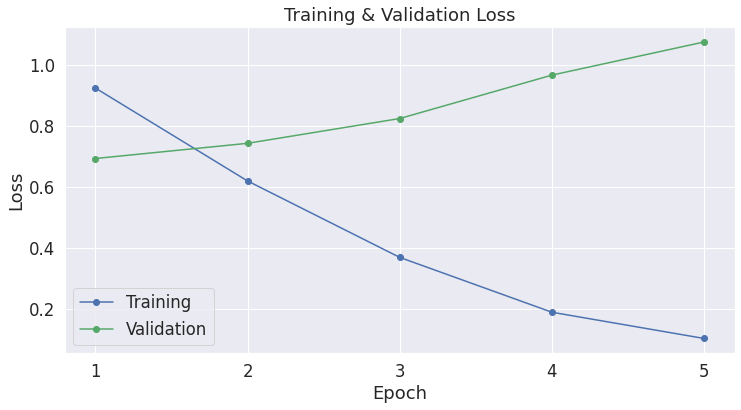

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

An **underfit** model can be identified from the learning curve of the training loss only.

It may show a flat line or noisy values of relatively high loss, indicating that the model was unable to learn the training dataset at all.

An example of this is provided below and is common when the model does not have a suitable capacity for the complexity of the dataset.

A plot of learning curves shows **underfitting** if:

- The training loss remains flat regardless of training.
- The training loss continues to decrease until the end of training.

A plot of learning curves shows **overfitting** if:

- The plot of training loss continues to decrease with experience.
- The plot of validation loss decreases to a point and begins increasing again.

A plot of learning curves shows a **good** fit if:

- The plot of training loss decreases to a point of stability.
- The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

## Loading the best model

In [ ]:
# model = torch.load('finetuned_model')
# model = torch.load('/content/gdrive/MyDrive/Colab Notebooks/Data Science/BERT/finetuned_model_256_Alberto')
model = torch.load('/content/gdrive/MyDrive/Colab Notebooks/Data Science/BERT/finetuned_model_32_Alberto')
MAX_LEN = 11
BATCH_SIZE = 32

## Test performance

In [ ]:

test_dataloader = DataLoader(
    tokenized_datasets["test"], sampler = SequentialSampler(tokenized_datasets["test"]), batch_size=BATCH_SIZE, collate_fn=data_collator
)

In [ ]:
len_ids = (len(tokenized_datasets["test"]["input_ids"]))

In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(tokenized_datasets["test"]["input_ids"])))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    # Add batch to GPU
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
      
    logits = outputs.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = batch["labels"].detach().cpu().numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 152 test sentences...
    DONE.


In [ ]:
from functools import reduce
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

from sklearn.metrics import accuracy_score
accuracy_score(scores, labels)

0.7302631578947368

## Confusion Matrix

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

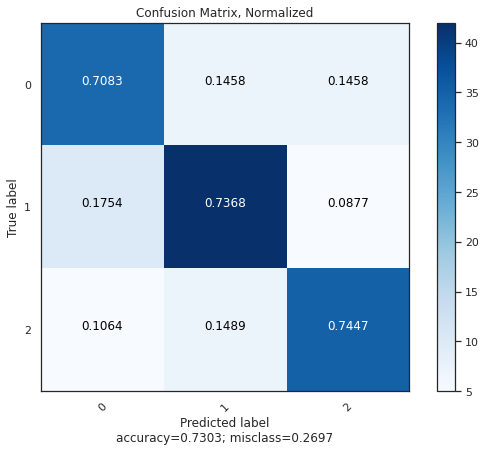

In [ ]:
# Plotting confusion matrix
sns.set(font_scale=1)
sns.set(style='white')


cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm, 
                      normalize    = True,
                      target_names = ['0', '1', '2'],
                      title        = "Confusion Matrix, Normalized")

## Test on unlabeled dataset

In [ ]:
# unlabeled dataset preparation
unlabeled_dataset = datasets.Dataset.from_dict(unlabeled_df)
unlabeled_test = datasets.DatasetDict({"unlabeled": unlabeled_dataset})
test_input_ids = []
test_attention_masks = []
test_tweets=unlabeled_test["unlabeled"]
# text extraction
test_tweets =  test_tweets["text"]


for tweet in test_tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,               
                        add_special_tokens = True, 
                        max_length = MAX_LEN,         
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE # Evaluate with this batch size.
        )

predictions = []
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()
            
            predictions.extend(list(pred_flat))

df_output = pd.DataFrame()
df_output['tweets']=test_tweets
df_output['label'] =predictions

# results
df_output

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


,tweets,label
0,guerra ucraina russia mosca avverte paesi balt...,1
1,russia invade ucraina covid parla pi nessuno b...,1
2,diegofusaro bisogno russia invade altri paesi ...,1
3,quartogrado poi nn ucraina invade russia russi...,0
4,flayawa russia certo democratica putin certo d...,0
...,...,...
15544,zevunderskin tv polacca continua spiegare citt...,0
15545,armamenti unico tema ormai conflitto ucraina r...,0
15546,messina denaro vescovo mazara basta omert parr...,0
15547,punti guerra ucraina tenere d occhio vista dec...,1


In [ ]:
# Analysis per label
results = df_output.groupby(['label']).count()
print(results)

       tweets
label        
0        7310
1        7137
2        1102


In [ ]:
res = df_output.sort_values(['label'])
res

,tweets,label
7774,rusembitaly vergogna vergogna vergogna solo te...,0
6251,ricordatevi bene oggi condanner criminidiguerr...,0
11668,nonostante cresce malumore russia credo minima...,0
6249,reznikov coraggio sar mai distrutto missili te...,0
6248,miliari russi comanda prende decisioni gran te...,0
...,...,...
7950,buongiorno ucraina s tco jamhfqucgd,2
1596,kharkiv fa molto pi freddo sappiamo bene solo ...,2
1598,giammarcosicuro buon natale ucraini sempre put...,2
1574,bacio buonanotte himars caserma rushista press...,2


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# torch.save(model, '/content/gdrive/MyDrive/Colab Notebooks/Data Science/BERT/finetuned_model__XXL')